# Clustering FFT + DBSCAN

Aplicamos **DBSCAN** (Density-Based Spatial Clustering) a features espectrales FFT.

**Ventajas de DBSCAN vs K-Means:**
- No requiere especificar número de clusters
- Detecta outliers automáticamente
- Encuentra clusters de forma arbitraria

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = [12, 6]

sys.path.append('../utils')
from clustering_utils import load_paired_signals, apply_fft_to_pairs, extract_simple_spectral_features, evaluate_clustering
from metrics_logger import ClusteringMetricsLogger

RESULTS_FILE = 'clustering_experiments.csv'
logger = ClusteringMetricsLogger(output_file=RESULTS_FILE)

print("Setup completado")

Setup completado


## 1. Carga de Datos y FFT

In [2]:
# Cargar y procesar datos
paired_data = load_paired_signals(
    signals_dir='../../data/Signals_Raw/',
    labels_csv='../../data/nivel_damage.csv',
    base_specimens_only=True,
    target_length=60000,
    verbose=False
)

fft_data = apply_fft_to_pairs(paired_data, sampling_rate=100)

print(f"Pares cargados: {len(paired_data)}")

🔄 PASO 2: Aplicando FFT a cada par (S2, S1)...
   ✓ A1: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A10: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A11: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A12: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A13: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A14: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A15: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A16: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A17: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.001

## 2. Extracción de Features

In [3]:
# Extraer features con transfer features
features_matrix, features_df, feature_names = extract_simple_spectral_features(
    fft_data,
    freq_range=(0, 20),
    include_transfer_features=True
)

# Normalizar
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_matrix)

labels_real = features_df['nivel_dano'].values
specimen_ids = features_df['specimen_id'].values

print(f"Features: {features_normalized.shape}")

🔄 Extrayendo características espectrales...
   Rango de frecuencias: 0 - 20 Hz
   Include transfer features: True
   ✓ A1 (N1): 36 features extraídas
   ✓ A10 (N2): 36 features extraídas
   ✓ A11 (N2): 36 features extraídas
   ✓ A12 (N1): 36 features extraídas
   ✓ A13 (N1): 36 features extraídas
   ✓ A14 (N1): 36 features extraídas
   ✓ A15 (N1): 36 features extraídas
   ✓ A16 (N1): 36 features extraídas
   ✓ A17 (N1): 36 features extraídas
   ✓ A18 (N1): 36 features extraídas
   ✓ A19 (N1): 36 features extraídas
   ✓ A2 (N1): 36 features extraídas
   ✓ A20 (N1): 36 features extraídas
   ✓ A21 (N1): 36 features extraídas
   ✓ A22 (N1): 36 features extraídas
   ✓ A23 (N2): 36 features extraídas
   ✓ A24 (N1): 36 features extraídas
   ✓ A25 (N2): 36 features extraídas
   ✓ A26 (N1): 36 features extraídas
   ✓ A27 (N1): 36 features extraídas
   ✓ A28 (N1): 36 features extraídas
   ✓ A29 (N1): 36 features extraídas
   ✓ A3 (N1): 36 features extraídas
   ✓ A30 (N1): 36 features extraídas
 

## 3. DBSCAN Clustering

### Selección de eps con k-distance plot

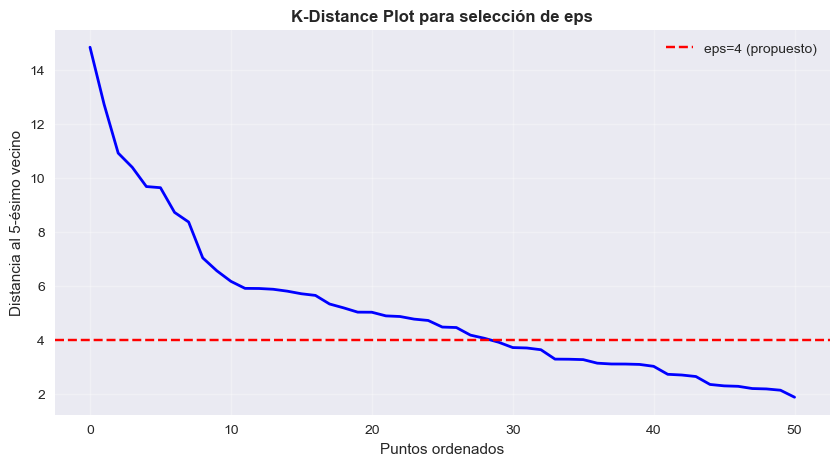

Buscar el 'codo' donde la curva cambia de pendiente → ese es el eps óptimo


In [4]:
# k-distance plot para encontrar eps óptimo
k = 5  # min_samples típico
neighbors = NearestNeighbors(n_neighbors=k)
neighbors.fit(features_normalized)
distances, _ = neighbors.kneighbors(features_normalized)

# Ordenar distancias al k-ésimo vecino
k_distances = np.sort(distances[:, k-1])[::-1]

plt.figure(figsize=(10, 5))
plt.plot(k_distances, 'b-', linewidth=2)
plt.axhline(y=4, color='red', linestyle='--', label='eps=4 (propuesto)')
plt.xlabel('Puntos ordenados')
plt.ylabel(f'Distancia al {k}-ésimo vecino')
plt.title('K-Distance Plot para selección de eps', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Buscar el 'codo' donde la curva cambia de pendiente → ese es el eps óptimo")

In [5]:
# Aplicar DBSCAN
eps = 5  # Ajustar según k-distance plot
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
cluster_labels = dbscan.fit_predict(features_normalized)

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_outliers = (cluster_labels == -1).sum()

print(f"DBSCAN (eps={eps}, min_samples={min_samples}):")
print(f"  Clusters encontrados: {n_clusters}")
print(f"  Outliers detectados: {n_outliers}")
print(f"\nDistribución:")
print(pd.Series(cluster_labels).value_counts().sort_index())

DBSCAN (eps=5, min_samples=5):
  Clusters encontrados: 1
  Outliers detectados: 12

Distribución:
-1    12
 0    39
Name: count, dtype: int64


In [6]:
# Tabla cruzada
print("Cluster vs Nivel de Daño:")
print(pd.crosstab(labels_real, cluster_labels, rownames=['Nivel'], colnames=['Cluster']))

Cluster vs Nivel de Daño:
Cluster  -1   0
Nivel          
N1       10  32
N2        1   6
N3        1   1


## 4. Visualización

In [7]:
# PCA para visualización
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_normalized)

print(f"Varianza explicada: {pca.explained_variance_ratio_.sum():.1%}")

Varianza explicada: 33.4%


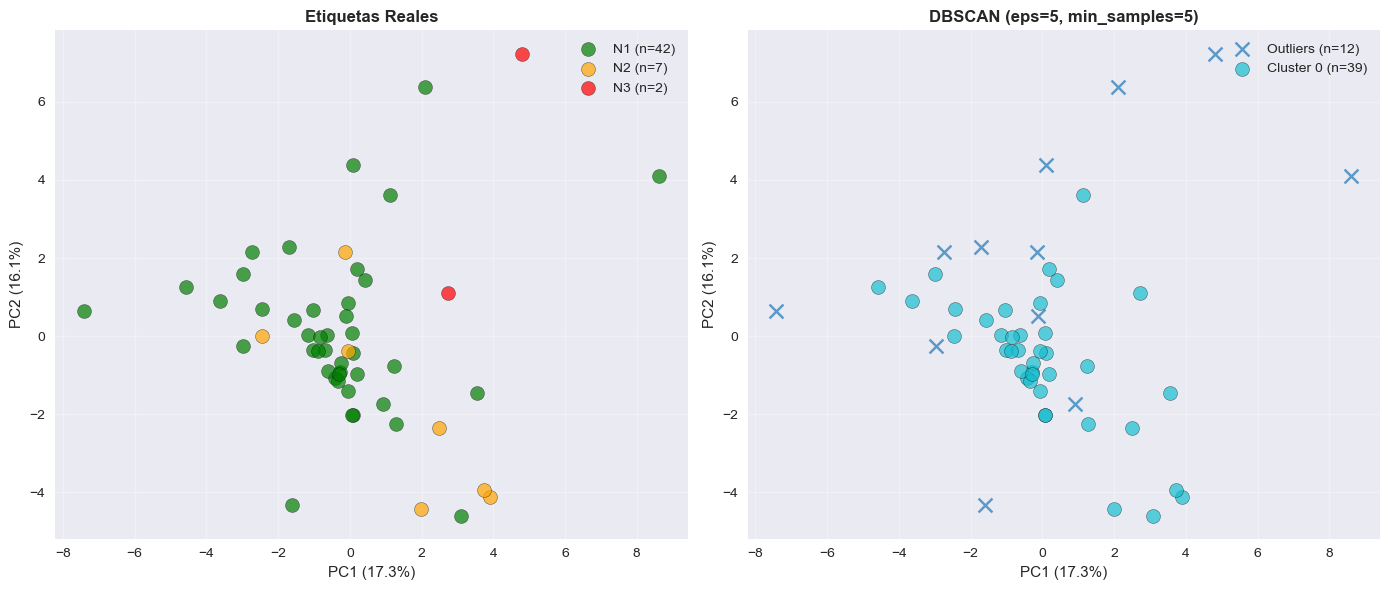

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Datos reales
colors_real = {'N1': 'green', 'N2': 'orange', 'N3': 'red'}
for nivel in ['N1', 'N2', 'N3']:
    mask = labels_real == nivel
    axes[0].scatter(features_pca[mask, 0], features_pca[mask, 1],
                    c=colors_real[nivel], label=f'{nivel} (n={mask.sum()})',
                    s=100, alpha=0.7, edgecolors='black')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[0].set_title('Etiquetas Reales', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Clusters DBSCAN
unique_labels = set(cluster_labels)
colors_cluster = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(sorted(unique_labels), colors_cluster):
    mask = cluster_labels == label
    name = 'Outliers' if label == -1 else f'Cluster {label}'
    marker = 'x' if label == -1 else 'o'
    axes[1].scatter(features_pca[mask, 0], features_pca[mask, 1],
                    c=[color], label=f'{name} (n={mask.sum()})',
                    s=100, alpha=0.7, edgecolors='black', marker=marker)

axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[1].set_title(f'DBSCAN (eps={eps}, min_samples={min_samples})', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Métricas y Registro

In [9]:
# Solo calcular métricas si hay más de 1 cluster (excluyendo outliers)
if n_clusters >= 2:
    # Para métricas, excluir outliers
    mask_no_outliers = cluster_labels != -1
    
    metrics = evaluate_clustering(
        features=features_normalized[mask_no_outliers],
        cluster_labels=cluster_labels[mask_no_outliers],
        labels_real=labels_real[mask_no_outliers],
        kmeans_model=None,
        experiment_name=f"FFT + DBSCAN (eps={eps}, min_samples={min_samples})"
    )
else:
    print("⚠️ DBSCAN encontró menos de 2 clusters. Ajustar parámetros eps/min_samples.")
    metrics = {}

⚠️ DBSCAN encontró menos de 2 clusters. Ajustar parámetros eps/min_samples.


In [10]:
# Registrar experimento
if metrics:
    logger.log_experiment(
        experiment_id=f"fft_dbscan_eps{eps}_min{min_samples}",
        notebook_name="4_clustering_fft_dbscan",
        algorithm="dbscan",
        frequency_transform="fft",
        n_clusters=n_clusters,
        pca_dims=2,
        feature_set="spectral_with_transfer",
        
        silhouette_score=metrics.get('silhouette'),
        davies_bouldin_index=metrics.get('davies_bouldin'),
        calinski_harabasz_score=metrics.get('calinski'),
        
        adjusted_rand_index=metrics.get('ari'),
        normalized_mutual_info=metrics.get('nmi'),
        homogeneity=metrics.get('homogeneity'),
        completeness=metrics.get('completeness'),
        v_measure=metrics.get('v_measure'),
        
        n_samples=len(features_normalized),
        n_features=features_normalized.shape[1],
        notes=f"DBSCAN eps={eps} min_samples={min_samples}, outliers={n_outliers}"
    )
    print(f"\n✅ Experimento registrado en: {RESULTS_FILE}")
else:
    print("❌ No se registró el experimento (insuficientes clusters)")

❌ No se registró el experimento (insuficientes clusters)
